In [1]:
%matplotlib inline

In [2]:
import datetime
import numpy as np 
import pandas as pd 
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.learning_curve import learning_curve
from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt
import prettyplotlib as ppl
import brewer2mpl
import random
from operator import itemgetter
import time
import copy

In [3]:
set2 = brewer2mpl.get_map('Set2', 'qualitative', 8).mpl_colors

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 16,
        }
plt.rc('font',family='serif')
plt.rc('font', size=16)
plt.rc('font', weight='bold')
plt.style.use('fivethirtyeight')
    
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Set figure width to 6 and height to 6
fig_size[0] = 6
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

### Load Data

In [4]:
train = pd.read_csv('data/act_train.csv', dtype={'people_id': np.str,
                               'activity_id': np.str,
                               'outcome': np.int8}, parse_dates=['date'])
test = pd.read_csv('data/act_test.csv', dtype={'people_id': np.str,
                              'activity_id': np.str}, parse_dates=['date'])
people = pd.read_csv('data/people.csv', dtype={'people_id': np.str,
                              'activity_id': np.str,
                              'char_38': np.int32},parse_dates=['date'])

### Cleanup Data - Date, FillNaN etc

In [5]:
def date_to_julian_day(row):
    """Returns the Julian day number of a date."""
    date_format = '%m/%d%Y'
    recorded_date = row['date']
    a = (14 - recorded_date.month)//12
    y = recorded_date.year + 4800 - a
    m = recorded_date.month + 12*a - 3
    return (recorded_date.day + ((153*m + 2)//5) + 365*y + y//4 - y//100 + y//400 - 320450)**0.5

In [6]:
print("Process tables...")
for table in [train, test]:
        table['year'] = table['date'].dt.year
        table['month'] = table['date'].dt.month
        table['day'] = table['date'].dt.day
        table['julian'] = table.apply(date_to_julian_day, axis=1)
        table.drop('date', axis=1, inplace=True)
        table['activity_category'] = table['activity_category'].str.lstrip('type ').astype(np.int32)
        for i in range(1, 11):
            table['char_' + str(i)].fillna('type -999', inplace=True)
            table['char_' + str(i)] = table['char_' + str(i)].str.lstrip('type ').astype(np.int32)
people['year'] = people['date'].dt.year
people['month'] = people['date'].dt.month
people['day'] = people['date'].dt.day
people['julian'] = people.apply(date_to_julian_day, axis=1)
people.drop('date', axis=1, inplace=True)
people['group_1'] = people['group_1'].str.lstrip('group ').astype(np.int32)
for i in range(1, 10):
        people['char_' + str(i)] = people['char_' + str(i)].str.lstrip('type ').astype(np.int32)
for i in range(10, 38):
        people['char_' + str(i)] = people['char_' + str(i)].astype(np.int32)

print("Merge...")
train = pd.merge(train, people, how='left', on='people_id', left_index=True)
train.fillna(-999, inplace=True)
test = pd.merge(test, people, how='left', on='people_id', left_index=True)
test.fillna(-999, inplace=True)

Process tables...
Merge...


### Select Features for Model

In [32]:
feature_cols = [col for col in train.columns if col not in ['people_id', 'activity_id','outcome']]
target = 'outcome'

In [33]:
feature_cols = ['char_38', 'char_3_y', 'char_6_y', 'char_10_y','char_7_y', 'char_8_y', 'char_9_y', 'group_1', 'julian_x', 'julian_y']

In [9]:
print('Length of train: ', len(train))
print('Length of test: ', len(test))
print('Features [{}]: {}'.format(len(feature_cols), sorted(feature_cols)))


Length of train:  2197291
Length of test:  498687
Features [10]: ['char_10_y', 'char_38', 'char_3_y', 'char_6_y', 'char_7_y', 'char_8_y', 'char_9_y', 'group_1', 'julian_x', 'julian_y']


In [65]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

### Function to Model ROC

In [66]:
def plot_roc(model, title):
    model.fit(X_train, y_train)
    actuals = y_train
    predictions  = model.predict(X_train)
    
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(actuals, predictions)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    
    actuals_t = y_test
    predictions_t  = model.predict(X_test)
    false_positive_rate_t, true_positive_rate_t, thresholds_t = metrics.roc_curve(actuals_t, predictions_t)
    roc_auc_t = metrics.auc(false_positive_rate_t, true_positive_rate_t)

    # Plot of a ROC curve for a specific class
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(false_positive_rate, true_positive_rate, 'r', label='Training = %0.2f'% roc_auc)
    plt.plot(false_positive_rate_t, true_positive_rate_t, 'g', label='Test = %0.2f'% roc_auc_t)
    plt.fill(false_positive_rate, true_positive_rate, facecolor='blue', alpha=0.5, )
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontdict=font)
    plt.ylabel('True Positive Rate', fontdict=font)
    title = "Redhat Dataset " + title
    plt.title(title, fontdict=font)
    plt.legend(loc="lower right", fontsize=20)
    #plt.savefig(name, bbox_inches='tight')
    plt.show()
    return roc_auc 

In [67]:
def plot_learning_curve(estimator, title, ylim=None):
    
    train_sizes=np.linspace(.1, 1.0, 5)
    cv=None
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    title = "RedHat Dataset - " + title
    plt.title(title, y=1.08, fontdict=font)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples", fontdict=font)
    plt.ylabel("Score", fontdict=font)
    plt.grid(True)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.plot(train_sizes, train_scores_mean, color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, color="g",
             label="Cross-validation score")
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()

In [68]:
def models(clf):
    start = time.time()
    print(clf)
    print("")
    clf.fit(X_train, y_train)
    # summarize the fit of the model
    expected = y_test
    predicted = clf.predict(X_test)
    
    # summarize the fit of the model
    score = clf.score(X_test, y_test)
    false_positive_rate_t, true_positive_rate_t, thresholds_t = metrics.roc_curve(expected, predicted)
    roc_auc_t = metrics.auc(false_positive_rate_t, true_positive_rate_t)
    
    print("ROC_AUC score using test set: {}\n".format(str(roc_auc_t)))
    print("="*66)
    print("")
    # train the model with whole training dataset now
    clf.fit(X, y)
    # make predictions
    expected = y
    predicted = clf.predict(X)
    # print confusion matrix
    cm = metrics.confusion_matrix(expected, predicted)
    target_names = ['bad', 'good']
    fig, ax = plt.subplots()
    sns_cm = sns.heatmap(cm, annot=True, fmt='', xticklabels=target_names, yticklabels=target_names , ax=ax)
    title = "RedHat Training Dataset - Confusion Matrix"
    ax.set_title(title, y=1.08, fontdict=font)
    fig.show()
    end = time.time()
    total = end-start
    minutes = total//60.0
    seconds = total%60.0
    print("Total running time for this model = {} seconds ({} minutes {} seconds)".format(total, minutes, seconds))
    print("")
    return

### KNN

In [76]:
from sklearn import neighbors

model = neighbors.KNeighborsClassifier(n_neighbors=20, weights='uniform', 
                                                 algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, 
                                                 n_jobs=-1)
model = neighbors.KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=54, p=1,
           weights='distance')

In [77]:
X = train[feature_cols]
Xt = test[feature_cols]
y = train['outcome']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

(1757832, 10)
(1757832,)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=54, p=1,
           weights='distance')

ROC_AUC score using test set: 0.996010614015


Total running time for this model = 3268.6080899238586 seconds (54.0 minutes 28.608089923858643 seconds)



/usr/local/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/usr/local/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


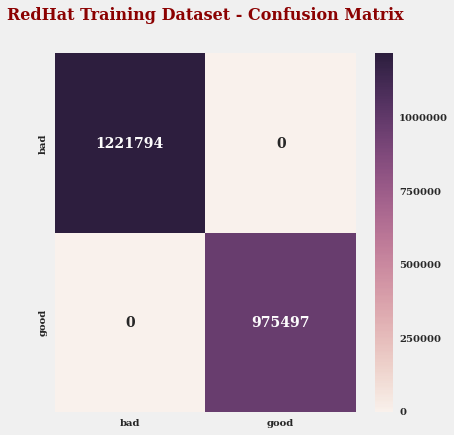

In [79]:
models(model)

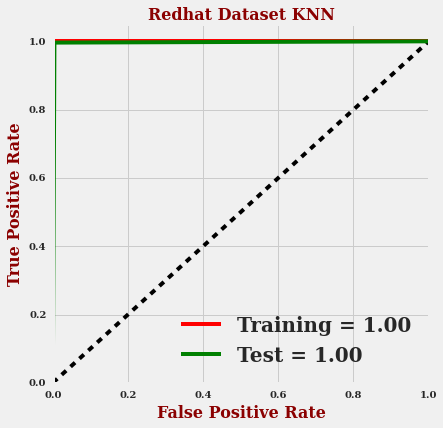

1.0

In [80]:
plot_roc(model, "KNN")

In [81]:
X_train1, X1, y_train1, y1 = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_test1.shape)
print(y_test1.shape)

(109865, 10)
(109865,)


In [82]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(model_KNN, X, y, n_jobs=-1, scoring="roc_auc", cv=5)
print(scores)
print("")
print(sum(scores)/len(scores))

[ 0.91012562  0.89920653  0.91771991  0.89560211  0.90124545]

0.904779924627


In [74]:
%%time
from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=2)
from sklearn.grid_search import GridSearchCV
from sklearn import ensemble

# Set the parameters by cross-validation 
tuned_parameters = [{'n_neighbors': list(range(40,60, 1)), 'weights': ['uniform', 'distance'], 'p': [1, 2]}] 

grid = GridSearchCV(neighbors.KNeighborsClassifier(), tuned_parameters,cv=5, scoring='roc_auc', n_jobs=-1)
# fit out model
grid.fit(X3, y3)

CPU times: user 7.29 s, sys: 1.74 s, total: 9.03 s
Wall time: 4min 19s


In [75]:
print(grid.best_estimator_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=54, p=1,
           weights='distance')


In [29]:
X2, X3, y2, y3 = train_test_split(X1, y1, test_size=0.2, random_state=42)
print(X2.shape)
print(y2.shape)

(351567, 10)
(351567,)


Neighbors: 10, Accuracy: 0.941246
Neighbors: 20, Accuracy: 0.918889
Neighbors: 30, Accuracy: 0.905281
Neighbors: 40, Accuracy: 0.894222
Neighbors: 50, Accuracy: 0.886759
Neighbors: 60, Accuracy: 0.882139
Neighbors: 70, Accuracy: 0.877782
Neighbors: 80, Accuracy: 0.874084
Neighbors: 90, Accuracy: 0.870056
Neighbors: 100, Accuracy: 0.866928
Neighbors: 110, Accuracy: 0.864754
Neighbors: 120, Accuracy: 0.861796
Neighbors: 130, Accuracy: 0.858724
Neighbors: 140, Accuracy: 0.857564
Neighbors: 150, Accuracy: 0.856187
Neighbors: 160, Accuracy: 0.854446
Neighbors: 170, Accuracy: 0.854424
Neighbors: 180, Accuracy: 0.853502
Neighbors: 190, Accuracy: 0.852137
Neighbors: 200, Accuracy: 0.852000


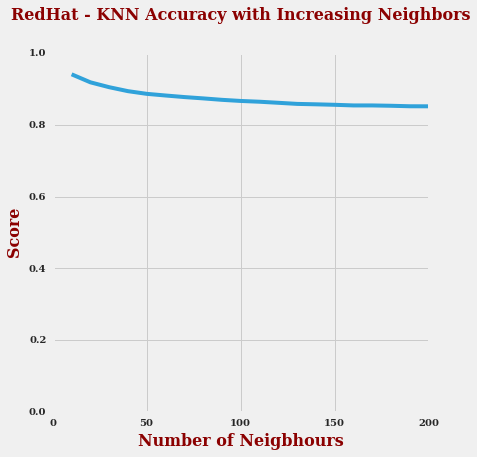

In [48]:
results = []
for n in range(10, 210, 10):
    clf = neighbors.KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=n, p=1, weights='uniform')
    clf.fit(X2, y2)
    preds = clf.predict(X3)
    accuracy = np.where(preds==y3, 1, 0).sum() / float(len(X3))
    print("Neighbors: %d, Accuracy: %3f" % (n, accuracy))

    results.append([n, accuracy])

results = pd.DataFrame(results, columns=["n", "accuracy"])
plt.ylim([0,1])
plt.plot(results.n, results.accuracy)
plt.xlabel("Number of Neigbhours", fontdict=font)
plt.ylabel("Score", fontdict=font)
plt.title("RedHat - KNN Accuracy with Increasing Neighbors", y=1.08, fontdict=font)
plt.show()

### Predict on Test Set

In [75]:
y_predict = model.predict_proba(Xt)

In [76]:
print(y_predict)

[[ 0.54775     0.45225   ]
 [ 0.54775     0.45225   ]
 [ 0.00742857  0.99257143]
 ..., 
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]]


In [77]:
yPred = y_predict[:,1]

In [78]:
current_time = datetime.datetime.now()

In [79]:
sub = pd.DataFrame()
sub['activity_id'] = test['activity_id']
sub['outcome'] = yPred.tolist()
sub.to_csv('submission_rf_' + str(current_time.strftime("%Y-%m-%d-%H-%M")) + '.csv', index=False)